<a href="https://colab.research.google.com/github/ishandahal/stats453-deep_learning_torch/blob/main/multi_layered_perceptron/Multilayered_perceptron_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Multi-layered Perceptron with Sigmoid activation and Mean Squared Error(MSE)

Implementing one hidden layer
- sigmoid activation in the hidden layer
- sigmoid activation in the output layer
- Mean Squared Error loss function

### Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [2]:
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

Settings and Datasets

In [3]:
## Setting

Random_seed = 1
batch_size = 100
num_epochs = 50

## mnist dataset

# transforms.ToTensor() scales input images
# to 0-1 range

train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
## Checking dataset
for image, label in train_loader:
    print(f"Image batch dimensions: {image.size()}\nImage label dimensions: {label.size()}")
    break

Image batch dimensions: torch.Size([100, 1, 28, 28])
Image label dimensions: torch.Size([100])


## Model Implementation

In [13]:
## Model

class MultilayerPerceptron():

    def __init__(self, num_features, num_hidden, num_classes):

        self.num_classes = num_classes

        # hidden_1
        self.weight_1 = torch.zeros(num_hidden, num_features,
                                    dtype=torch.float).normal_(0.0, 0.1)
        self.bias_1 = torch.zeros(num_hidden, dtype=torch.float)

        # output 
        self.weight_2 = torch.zeros(num_classes, num_hidden,
                                    dtype=torch.float).normal_(0, 0.1)
        self.bias_2 = torch.zeros(num_classes, dtype=torch.float)

    def forward(self, x):
        # hidden_1
        # input dim: [num_examples, num_features] dot [num_hidden, num_features].T
        # out dim: [num_examples, num_hidden]

        z_1 = torch.add(torch.mm(x, self.weight_1.t()), self.bias_1)
        a_1 = torch.sigmoid(z_1)

        # hidden_2
        ## input dim: [num_examples, num_hidden] dot [num_classes, num_hidden].T
        # output dim: [num_examples, num_classes]
        z_2 = torch.add(torch.mm(a_1, self.weight_2.t()), self.bias_2)
        a_2 = torch.sigmoid(z_2)
        return a_1, a_2
    
    def backward(self, x, a_1, a_2, y):
        ## output layer weights 

        #onehot encoding 
        y_onehot = torch.FloatTensor(y.size(0), self.num_classes)
        y_onehot.zero_()
        y_onehot.scatter_(1, y.view(-1, 1).long(), 1)

        # Part 1: dLoss/dOutWeights 
        ## = dLoss/dOutAcc * dOutAct/doutNet * dOutNet/dOutWeight
        ## where Deltaout = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient reuse

        # input/out dim: [n_examples, n_classes]
        dloss_da2 = 2.*(a_2 - y_onehot) / y.size(0)

        # input/output dim: [n_examples, n_classes]
        da2_dz2 = a_2 * (1. - a_2) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = dloss_da2 * da2_dz2  # "delta (rule) placeholder"

        # gradient for output weights

        # [n_examples, n_hidden]
        dz2__dw_out = a_1

        # input dim: [n_classlabels, n_examples] dot [n_examples, n_hidden]

        # output dim:  [n_classlabels, n_hidden]
        dloss__dw_out = torch.mm(delta_out.t(), dz2__dw_out)
        dloss__db_out = torch.sum(delta_out, dim=0)

        ## Part 2: dLoss/dHiddenWeights
        # Delta Out * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        dz2__a1 = self.weight_2

        # output dim: [n_examples, n_hidden]
        dloss_a1 = torch.mm(delta_out, dz2__a1)

        # [n_examples, n_hidden]
        da1__dz1 = a_1 * (1. - a_1) # sigmoid derivative

        # [n_examples, n_features]
        dz1__dw1 = x

        # output dim: [n_hidden, n_features]
        dloss_dw1 = torch.mm((dloss_a1 * da1__dz1).t(), dz1__dw1)
        dloss_db1 = torch.sum((dloss_a1 * da1__dz1), dim=0)

        return dloss__dw_out, dloss__db_out, dloss_dw1, dloss_db1

### Training

In [15]:
## Training and evaluation wrappers

def to_onehot(y, num_classes):
    y_onehot = torch.FloatTensor(y.size(0), num_classes)
    y_onehot.zero_()
    y_onehot.scatter_(1, y.view(-1, 1).long(), 1).float()
    return y_onehot

def loss_func(targets_onehot, probas_onehot):
    return torch.mean(torch.mean((targets_onehot - probas_onehot)**2, dim=0))

def compute_mse(net, data_loader):
    curr_mse, num_examples = torch.zeros(model.num_classes).float(), 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28)
            logits, probas = net.forward(features)
            y_onehot = to_onehot(targets, model.num_classes)
            loss = torch.sum((y_onehot - probas)**2, dim=0)
            num_examples += targets.size(0)
            curr_mse += loss
        
        curr_mse = torch.mean(curr_mse/num_examples, dim=0)
        return curr_mse

def train(model, dataloader, num_epochs,
          learning_rate=0.1):
    
    minibatch_cost = []
    epoch_cost = []

    for e in range(num_epochs):

        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.view(-1, 28*28)

            # compute outputs
            a_1, a_2 = model.forward(features)

            # compute gradients
            dloss__dw_out, dloss__db_out, dloss_dw1, dloss_db1 = \
                model.backward(features, a_1, a_2, targets)

            ## Update weights
            model.weight_1 -= learning_rate * dloss_dw1
            model.bias_1 -= learning_rate * dloss_db1
            model.weight_2 -= learning_rate * dloss__dw_out
            model.bias_2 -= learning_rate * dloss__db_out

            ## Logging 
            curr_cost = loss_func(to_onehot(targets, model.num_classes), a_2)

            minibatch_cost.append(curr_cost)
            if not batch_idx % 50:
                print(f"Epoch: {e+1:03d}/{num_epochs} | Batch {batch_idx:03d}/{len(train_loader):03d}"
                      f"| Cost: {curr_cost:.4f}")
                
        ## Logging 
        curr_cost = compute_mse(model, train_loader)
        epoch_cost.append(curr_cost)
        print(f"Epoch: {e+1:03d}/{num_epochs:03d}", end="")
        print(f" Train MSE: {curr_cost:.5f}")
    
    return minibatch_cost, epoch_cost

In [16]:
#### training
torch.manual_seed(Random_seed)
model = MultilayerPerceptron(num_features=28*28,
                             num_hidden=50,
                             num_classes=10)

minibatch_cost, epoch_cost = train(model,
                                   train_loader,
                                   num_epochs=num_epochs,
                                   learning_rate=0.1)

Epoch: 001/50 | Batch 000/600| Cost: 0.2386
Epoch: 001/50 | Batch 050/600| Cost: 0.0895
Epoch: 001/50 | Batch 100/600| Cost: 0.0879
Epoch: 001/50 | Batch 150/600| Cost: 0.0878
Epoch: 001/50 | Batch 200/600| Cost: 0.0845
Epoch: 001/50 | Batch 250/600| Cost: 0.0845
Epoch: 001/50 | Batch 300/600| Cost: 0.0828
Epoch: 001/50 | Batch 350/600| Cost: 0.0817
Epoch: 001/50 | Batch 400/600| Cost: 0.0740
Epoch: 001/50 | Batch 450/600| Cost: 0.0728
Epoch: 001/50 | Batch 500/600| Cost: 0.0721
Epoch: 001/50 | Batch 550/600| Cost: 0.0729
Epoch: 001/050 Train MSE: 0.06567
Epoch: 002/50 | Batch 000/600| Cost: 0.0652
Epoch: 002/50 | Batch 050/600| Cost: 0.0585
Epoch: 002/50 | Batch 100/600| Cost: 0.0616
Epoch: 002/50 | Batch 150/600| Cost: 0.0625
Epoch: 002/50 | Batch 200/600| Cost: 0.0586
Epoch: 002/50 | Batch 250/600| Cost: 0.0613
Epoch: 002/50 | Batch 300/600| Cost: 0.0502
Epoch: 002/50 | Batch 350/600| Cost: 0.0513
Epoch: 002/50 | Batch 400/600| Cost: 0.0465
Epoch: 002/50 | Batch 450/600| Cost: 0.051

## Evaluation

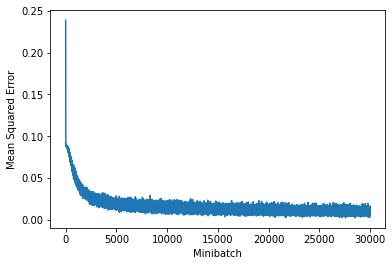

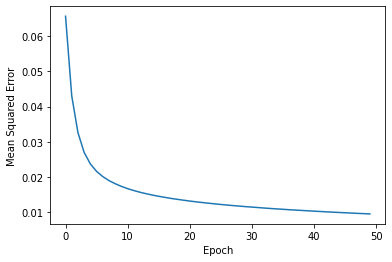

In [17]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

In [20]:
def compute_accuracy(net, dataloader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in dataloader:
            features = features.view(-1, 28*28)
            _, outputs = net.forward(features)
            predicted_labels = torch.argmax(outputs, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100

print(f"Training accuracy: {compute_accuracy(model, train_loader):.2f}%")
print(f"Test accuracy: {compute_accuracy(model, test_loader):.2f}%")

Training accuracy: 94.69%
Test accuracy: 94.53%


## Visual Inspections

In [21]:
import matplotlib
import matplotlib.pyplot as plt

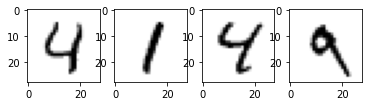

In [31]:
for features, targets in test_loader:
    break

fig, ax = plt.subplots(1, 4)
for i in range(4, 8):
    ax[i-4].imshow(features[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

In [32]:
_, predictions = model.forward(features[4:8].view(-1, 28*28))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions)

Predicted labels tensor([4, 1, 4, 9])
